In [1]:
import tempfile

import requests
import rasterio
import rasterio.windows
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer

In [2]:
run = 'bbwduc-ERD2018-EBIRD_SCIENCE-20191105-dc3957b5'
example_url = f'https://s3-us-west-2.amazonaws.com/ebirdst-data/{run}/results/tifs/{run}_hr_2018_occurrence_median.tif'
folder = tempfile.TemporaryDirectory()
with open(folder.name + '/example.tif', 'wb') as f:
    f.write(requests.get(example_url).content)

In [3]:
dataset = rasterio.open(folder.name + '/example.tif')

In [4]:
print(dataset.count, dataset.height, dataset.width)

52 5630 7074


In [5]:
def show(array):
    f, ax = plt.subplots(1, figsize=(10, 7))
    ax.matshow(array);
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_color('grey')
    return ax

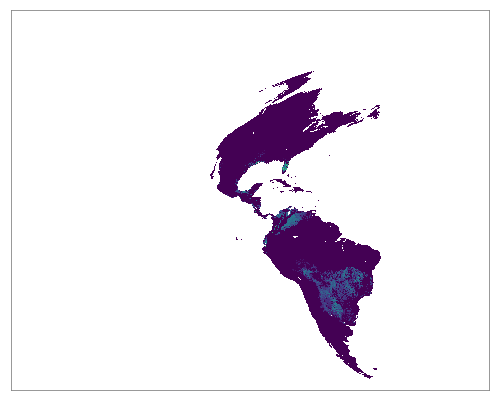

In [6]:
# First week of the year, dead of winter
show(dataset.read(1));

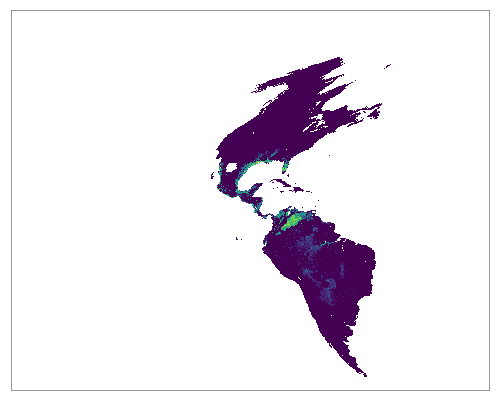

In [7]:
# 26th week of the year, mid summer
show(dataset.read(26));

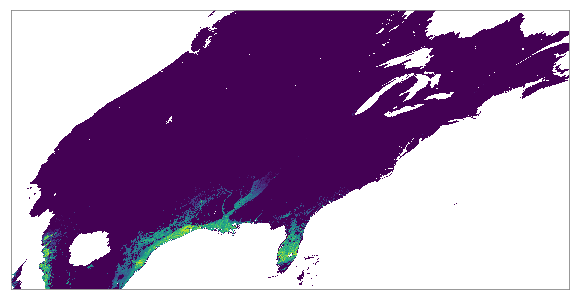

In [8]:
# We can easily filter the dataset to the USA.
window = rasterio.windows.Window(2950, 1400, 2200, 1100)
show(dataset.read(26, window=window));

In [9]:
x = dataset.read(window=window)
x.shape

(52, 1100, 2200)

In [10]:
# What if we also downsample by a factor of 10 in each spatial dimension?
kwargs = dataset.meta.copy()
down_ratio = 10
t = rasterio.windows.transform(window, dataset.transform)
transform = rasterio.Affine(
    t.a * down_ratio, t.b, t.c, t.d, t.e * down_ratio, t.f
)
kwargs.update({
    'height': window.height // down_ratio,
    'width': window.width // down_ratio,
    'transform': transform,
    'compress': 'deflate'})

with rasterio.open(folder.name + '/reduced.tif', 'w', **kwargs) as new_dataset:
    data = dataset.read(window=window)
    data = np.nan_to_num(data, nan=np.nan, neginf=np.nan)
    data = np.nanmean(
        [
            data[:, i::down_ratio, j::down_ratio]
            for i in range(down_ratio)
            for j in range(down_ratio)
        ],
        axis=0
    )
    new_dataset.write(data)
dataset_reduced = rasterio.open(folder.name + '/reduced.tif')

<ipython-input-10-86a7e0538db1>:17: RuntimeWarning: Mean of empty slice
  data = np.nanmean(


In [11]:
from pathlib import Path
[(f, f.stat().st_size / 10**9) for f in Path(folder.name).glob('*')]

[(PosixPath('/tmp/tmp61conyai/reduced.tif'), 0.000260934),
 (PosixPath('/tmp/tmp61conyai/example.tif'), 0.106236129)]

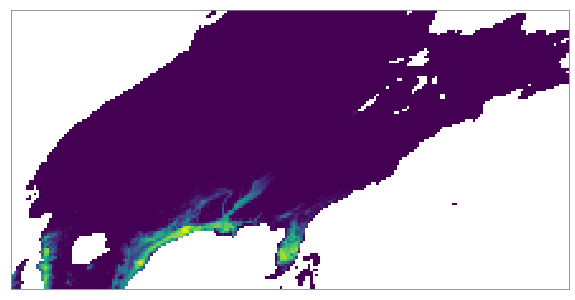

In [12]:
show(dataset_reduced.read(26));

In [13]:
# transformer from lat/long to dataset coordinates
# use always_xy to make it long/lat
transformer = Transformer.from_crs("EPSG:4326", dataset_reduced.crs)

In [14]:
transformer.transform(41.6, -80)

(-6652115.803282049, 4625714.162228736)

In [15]:
# Check some extreme points for IndexErrors
print(dataset_reduced.read(26)[dataset_reduced.index(*transformer.transform(26.87, -80.3))])
print(dataset_reduced.read(26)[dataset_reduced.index(*transformer.transform(47.306303, -72.182394))])
print(dataset_reduced.read(26)[dataset_reduced.index(*transformer.transform(49.768897, -66.736356))])
print(dataset_reduced.read(26)[dataset_reduced.index(*transformer.transform(48.966602, -95.318046))])

0.46504298
0.0
0.0
0.0


In [16]:
# Investigate what is necessary to save to preserve transformation info
np.array(transform)

array([ 2.96280666e+04,  0.00000000e+00, -1.12748297e+07,  0.00000000e+00,
       -2.96280898e+04,  5.85962211e+06,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00])

In [17]:
np.array(transform[:-3])

array([    29628.06660532,         0.        , -11274829.70542943,
               0.        ,    -29628.0897995 ,   5859622.10507058])

In [18]:
dataset_reduced.index(*transformer.transform(41.6, -80))

(41, 156)

In [19]:
((~transform) * transformer.transform(41.6, -80))[::-1]

(41.64655741197444, 156.0248248300047)

In [20]:
dataset_reduced.crs.wkt

'PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'

In [21]:
transformer.transform(41.6, -80)

(-6652115.803282049, 4625714.162228736)

In [22]:
Transformer.from_crs("EPSG:4326", dataset_reduced.crs.wkt).transform(41.6, -80)

(-6652115.803282049, 4625714.162228736)